<a href="https://colab.research.google.com/github/Mvgrillo1357/Ai-Platform-Engineering/blob/master/Ai-Platform-Engineering/ml_applied_to_coronavirus/Coronavirus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/kimjihoo/coronavirusdataset#case.csv the dataset source

#Access Kaggle

In [1]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install kaggle


In [0]:
!mkdir .kaggle
!mkdir ~/.kaggle

In [0]:
import json
token = {"username":"michaelgrillo","key":"1b1b61b21b7bd669c2b170bf718b9cd8"}
with open ('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

In [0]:
!chmod 600 /content/.kaggle/kaggle.json

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [6]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [7]:
!kaggle datasets download -d kimjihoo/coronavirusdataset -p /content --force

  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 85.4MB/s]


In [8]:
!unzip \*.zip

Archive:  coronavirusdataset.zip
  inflating: Case.csv                
  inflating: PatientInfo.csv         
  inflating: PatientRoute.csv        
  inflating: Region.csv              
  inflating: SearchTrend.csv         
  inflating: SeoulFloating.csv       
  inflating: Time.csv                
  inflating: TimeAge.csv             
  inflating: TimeGender.csv          
  inflating: TimeProvince.csv        
  inflating: Weather.csv             


In [9]:
!ls

Case.csv		Region.csv	   TimeAge.csv	     Weather.csv
coronavirusdataset.zip	sample_data	   Time.csv
PatientInfo.csv		SearchTrend.csv    TimeGender.csv
PatientRoute.csv	SeoulFloating.csv  TimeProvince.csv


#Import Libraries

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import scipy as sp
!pip install geopandas
import sklearn as skl
import geopandas as gpd
import geopy
import folium
from shapely.geometry import Point, Polygon
from sklearn.cluster import KMeans
from shapely.ops import nearest_points
from geopy.geocoders import Nominatim
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, mean_squared_error
from collections import Counter
from sklearn.datasets import make_classification
!pip install imblearn
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import pickle as plk
import math
import matplotlib as mpl
from sklearn.neighbors import NearestNeighbors
!pip install kmodes
from kmodes.kmodes import KModes

     |████████████████████████████████| 931kB 4.9MB/s 
     |████████████████████████████████| 10.4MB 19.0MB/s 
     |████████████████████████████████| 14.7MB 213kB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


#Make Dataframes

In [0]:
import io
df_case = pd.read_csv('Case.csv')
df_patientroute = pd.read_csv('PatientRoute.csv')
df_region = pd.read_csv('Region.csv')
df_patientinfo = pd.read_csv('PatientInfo.csv')
df_searchtrend=pd.read_csv('SearchTrend.csv')
df_timeage=pd.read_csv('TimeAge.csv')
df_time=pd.read_csv('Time.csv')
df_timegender=pd.read_csv('TimeGender.csv')
df_timeprovince=pd.read_csv('TimeProvince.csv')
df_weather=pd.read_csv('Weather.csv')

#DF Case

In [12]:
df_case.head()

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
0,1000001,Seoul,Guro-gu,True,Guro-gu Call Center,79,37.508163,126.884387
1,1000002,Seoul,Dongdaemun-gu,True,Dongan Church,24,37.592888,127.056766
2,1000003,Seoul,Eunpyeong-gu,True,Eunpyeong St. Mary's Hospital,14,37.63369,126.9165
3,1000004,Seoul,Seongdong-gu,True,Seongdong-gu APT,13,37.55713,127.0403
4,1000005,Seoul,Jongno-gu,True,Jongno Community Center,10,37.57681,127.006


In [13]:
df_case.latitude.unique()

array(['37.508163', '37.592888', '37.63369', '37.55713', '37.57681',
       '37.562405', '-', '35.21628', '35.16708', '35.20599', '35.17371',
       '35.84008', '36.504713', '36.48025', '37.38833', '37.455687',
       '37.2376', '36.82422', '36.81503', '37.000354', '35.64887',
       '36.92757', '36.0581', '35.782149', '35.84819', '35.82558',
       '35.68556', '35.805681', '35.22115', '35.54127'], dtype=object)

It looks like the null values are described as "-" these values need to be handled.

Fascinating, According to https://www.nytimes.com/2020/03/10/world/asia/south-korea-coronavirus-shincheonji.html and https://www.christianitytoday.com/news/2020/february/korea-coronavirus-shincheonji-church-daegu-covid19.html , Shincheonji Church is a haven for the virus. That may make it difficult to handle this data especially since the dataset states they are from other cities so this will have to be dropped. The Pilgrimage to Israel is impossible to tell where in the pilgrimmage the infection originated from. According to https://www.christianitytoday.com/news/2020/february/korea-coronavirus-churches-close-sunday-shincheonji-covid19.html Onchun Church is “investigating the possibility of Shincheonji’s infiltrating into our church” so that could mean that the virus was spread from Shincheonji Church!?!

Additionally there are points that are represented as "etc." and "overseas inflow" which are impossible to impute.

This data table is not great for my needs but dropping the null "-" values may allow me to conduct reasonable geospatial analysis.


now that we have the non null values we can conduct further analysis

In [14]:
badpoints=df_case.loc[df_case['latitude']== '-']
badpoints

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
6,1000007,Seoul,from other city,True,Shincheonji Church,6,-,-
7,1000008,Seoul,-,False,etc,65,-,-
9,1100002,Busan,from other city,True,Shincheonji Church,8,-,-
13,1100006,Busan,from other city,True,Cheongdo Daenam Hospital,1,-,-
14,1100007,Busan,-,False,etc,32,-,-
16,1200002,Daegu,-,False,contact with patient,649,-,-
17,1200003,Daegu,from other city,True,Cheongdo Daenam Hospital,2,-,-
18,1200004,Daegu,-,False,etc,1056,-,-
19,1300001,Gwangju,from other city,True,Shincheonji Church,9,-,-
20,1300002,Gwangju,-,False,contact with patient,4,-,-


In [15]:
df_casef = df_case[df_case.latitude != '-']
df_casef

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
0,1000001,Seoul,Guro-gu,True,Guro-gu Call Center,79,37.508163,126.884387
1,1000002,Seoul,Dongdaemun-gu,True,Dongan Church,24,37.592888,127.056766
2,1000003,Seoul,Eunpyeong-gu,True,Eunpyeong St. Mary's Hospital,14,37.63369,126.9165
3,1000004,Seoul,Seongdong-gu,True,Seongdong-gu APT,13,37.55713,127.0403
4,1000005,Seoul,Jongno-gu,True,Jongno Community Center,10,37.57681,127.006
5,1000006,Seoul,Jung-gu,True,Jung-gu Fashion Company,7,37.562405,126.984377
8,1100001,Busan,Dongnae-gu,True,Onchun Church,34,35.21628,129.0771
10,1100003,Busan,Suyeong-gu,True,Suyeong-gu Kindergarten,6,35.16708,129.1124
11,1100004,Busan,Haeundae-gu,True,Haeundae-gu Catholic Church,6,35.20599,129.1256
12,1100005,Busan,Jin-gu,True,Jin-gu Academy,4,35.17371,129.0633


In [16]:
greatpoints=pd.DataFrame(data=df_casef, columns=['case_id','latitude','longitude'])
greatpoints

,case_id,latitude,longitude
0,1000001,37.508163,126.884387
1,1000002,37.592888,127.056766
2,1000003,37.63369,126.9165
3,1000004,37.55713,127.0403
4,1000005,37.57681,127.006
5,1000006,37.562405,126.984377
8,1100001,35.21628,129.0771
10,1100003,35.16708,129.1124
11,1100004,35.20599,129.1256
12,1100005,35.17371,129.0633


#Make DF Case Geodataframe

In order to easily map the data I created a geodataframe.

It turns out WGS84 stands for World Geodetic System 1984 and the crs for this is actually EPSG:3395.

In [17]:
def create_gdf(df_casef, lng, lat):
    "Convert pandas dataframe into a Geopandas GeoDataFrame"
    crs = {'init': 'EPSG:3395'}
    xlng= pd.to_numeric(df_casef['longitude'], errors='coerce')
    ylat= pd.to_numeric(df_casef['latitude'], errors='coerce')
    geometry = [Point(xy) for xy in zip(xlng, ylat)]
    gdf2 = gpd.GeoDataFrame(df_casef, crs= crs , geometry=geometry)
    return gdf2
gdf_casef =  create_gdf(df_casef, "longitude", "latitude")
gdf_casef.tail()

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,case_id,province,city,group,infection_case,confirmed,latitude,longitude,geometry
71,6000008,Gyeongsangbuk-do,Gyeongsan-si,True,Gyeongsan Cham Joeun Community Center,16,35.82558,128.7373,POINT (128.73730 35.82558)
74,6100002,Gyeongsangnam-do,Geochang-gun,True,Geochang Church,10,35.68556,127.9127,POINT (127.91270 35.68556)
75,6100003,Gyeongsangnam-do,Geochang-gun,True,Geochang-gun Woongyang-myeon,8,35.805681,127.917805,POINT (127.91781 35.80568)
76,6100004,Gyeongsangnam-do,Changwon-si,True,Hanmaeum Changwon Hospital,7,35.22115,128.6866,POINT (128.68660 35.22115)
77,6100005,Gyeongsangnam-do,Changnyeong-gun,True,Changnyeong Coin Karaoke,7,35.54127,128.5008,POINT (128.50080 35.54127)


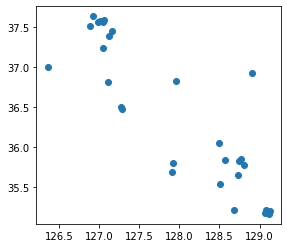

In [18]:
gdf_casef.plot()

Let's see if we can find the minimum haversine distance to optimize medical resource placement/ find centroids of the clusters of greatest problems to find the features of those centroids.

#DF Patientroute

In [19]:
df_patientroute.tail()

,patient_id,global_num,date,province,city,latitude,longitude
170,1200000031,31,2020-02-09,Daegu,Nam-gu,35.83982,128.5666
171,1200000031,31,2020-02-15,Daegu,Dong-gu,35.88241,128.6621
172,1200000031,31,2020-02-16,Daegu,Nam-gu,35.83982,128.5666
173,1200000031,31,2020-02-17,Daegu,Suseong-gu,35.84473,128.6123
174,1200000031,31,2020-02-18,Daegu,Seo-gu,35.85959,128.5406


In [20]:
badroutes=df_patientroute.loc[df_patientroute['latitude']== '-']
badroutes

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,patient_id,global_num,date,province,city,latitude,longitude


Good this data is complete. We can use this 

In [21]:
df_patientroute.isnull().sum()

patient_id    0
global_num    0
date          0
province      0
city          0
latitude      0
longitude     0
dtype: int64

#GDF Patientroute

In [22]:
def create_gdf2(df_patientroute, lng, lat):
    "Convert pandas dataframe into a Geopandas GeoDataFrame"
    crs = {'init': 'EPSG:3395'}
    xlng= pd.to_numeric(df_patientroute['longitude'], errors='coerce')
    ylat= pd.to_numeric(df_patientroute['latitude'], errors='coerce')
    geometry = [Point(xy) for xy in zip(xlng, ylat)]
    gdf3 = gpd.GeoDataFrame(df_patientroute, crs= crs , geometry=geometry)
    return gdf3
gdf_patientroutef =  create_gdf2(df_patientroute, "longitude", "latitude")
gdf_patientroutef.tail()

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,patient_id,global_num,date,province,city,latitude,longitude,geometry
170,1200000031,31,2020-02-09,Daegu,Nam-gu,35.83982,128.5666,POINT (128.56660 35.83982)
171,1200000031,31,2020-02-15,Daegu,Dong-gu,35.88241,128.6621,POINT (128.66210 35.88241)
172,1200000031,31,2020-02-16,Daegu,Nam-gu,35.83982,128.5666,POINT (128.56660 35.83982)
173,1200000031,31,2020-02-17,Daegu,Suseong-gu,35.84473,128.6123,POINT (128.61230 35.84473)
174,1200000031,31,2020-02-18,Daegu,Seo-gu,35.85959,128.5406,POINT (128.54060 35.85959)


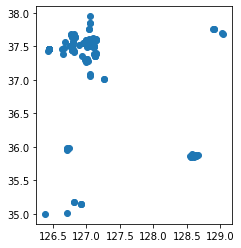

In [23]:
gdf_patientroutef.plot()

# DF Region

In [24]:
df_region.head()

,code,province,city,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
0,10000,Seoul,Seoul,37.566953,126.977977,607,830,48,1.44,15.38,5.8,22739
1,10010,Seoul,Gangnam-gu,37.518421,127.047222,33,38,0,4.18,13.17,4.3,3088
2,10020,Seoul,Gangdong-gu,37.530492,127.123837,27,32,0,1.54,14.55,5.4,1023
3,10030,Seoul,Gangbuk-gu,37.639938,127.025508,14,21,0,0.67,19.49,8.5,628
4,10040,Seoul,Gangseo-gu,37.551166,126.849506,36,56,1,1.17,14.39,5.7,1080


In [25]:
df_region.isnull().sum()

code                        0
province                    0
city                        0
latitude                    0
longitude                   0
elementary_school_count     0
kindergarten_count          0
university_count            0
academy_ratio               0
elderly_population_ratio    0
elderly_alone_ratio         0
nursing_home_count          0
dtype: int64

This data may need to be included joined with case data so that we can understand commonalities between areas with cases of coronavirus and areas without cases of coronavirus. 

In [26]:
df_region['city'].count()

244

In [27]:
df_region.dtypes

code                          int64
province                     object
city                         object
latitude                    float64
longitude                   float64
elementary_school_count       int64
kindergarten_count            int64
university_count              int64
academy_ratio               float64
elderly_population_ratio    float64
elderly_alone_ratio         float64
nursing_home_count            int64
dtype: object

#DF Patient Info

In [28]:
df_patientinfo.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [29]:
df_patientinfo.shape

(2243, 18)

In [30]:
df_patientinfo.infection_case.unique()

array(['overseas inflow', 'contact with patient', 'Seongdong-gu APT',
       'etc', "Eunpyeong St. Mary's Hospital", 'Shincheonji Church',
       'Dongan Church', 'Guro-gu Call Center', 'Onchun Church',
       'Cheongdo Daenam Hospital', 'Suyeong-gu Kindergarten', nan,
       'Ministry of Oceans and Fisheries', 'gym facility in Cheonan',
       'gym facility in Sejong', 'River of Grace Community Church',
       'Pilgrimage to Israel'], dtype=object)

In [31]:
df_patientinfo.isnull().sum()

patient_id               0
global_num             906
sex                     96
birth_year             454
age                    258
country                  0
province                 0
city                    67
disease               2224
infection_case        1050
infection_order       2201
infected_by           1768
contact_number        1830
symptom_onset_date    2049
confirmed_date         145
released_date         2010
deceased_date         2213
state                   96
dtype: int64

In [32]:
df_patientinfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2243 entries, 0 to 2242
Data columns (total 18 columns):
patient_id            2243 non-null int64
global_num            1337 non-null float64
sex                   2147 non-null object
birth_year            1789 non-null float64
age                   1985 non-null object
country               2243 non-null object
province              2243 non-null object
city                  2176 non-null object
disease               19 non-null object
infection_case        1193 non-null object
infection_order       42 non-null float64
infected_by           475 non-null float64
contact_number        413 non-null float64
symptom_onset_date    194 non-null object
confirmed_date        2098 non-null object
released_date         233 non-null object
deceased_date         30 non-null object
state                 2147 non-null object
dtypes: float64(5), int64(1), object(12)
memory usage: 315.5+ KB


In [33]:
df_patientinfo['state'].nunique()

3

In [0]:
statuscount=df_patientinfo.state.unique()

count_status=[]
for i in df_patientinfo.state.unique():
    count_status.append(df_patientinfo[df_patientinfo['state']==i].count()['patient_id'])

In [35]:
statuscount

array(['released', 'isolated', 'deceased', nan], dtype=object)

In [36]:
count_status

[314, 1801, 32, 0]

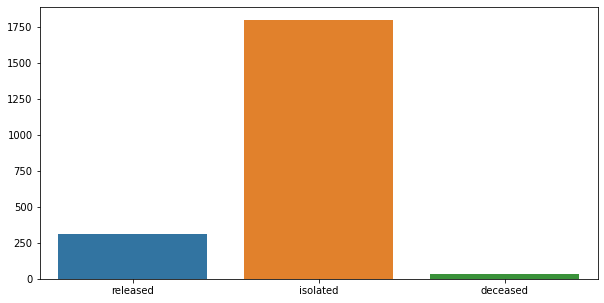

In [37]:
plt.figure(figsize=(10,5))
sns.barplot(statuscount, count_status)

In [38]:
df_patientinfo.disease.unique()

array([nan, True], dtype=object)

In [39]:
df_patientinfo.infection_case.unique()

array(['overseas inflow', 'contact with patient', 'Seongdong-gu APT',
       'etc', "Eunpyeong St. Mary's Hospital", 'Shincheonji Church',
       'Dongan Church', 'Guro-gu Call Center', 'Onchun Church',
       'Cheongdo Daenam Hospital', 'Suyeong-gu Kindergarten', nan,
       'Ministry of Oceans and Fisheries', 'gym facility in Cheonan',
       'gym facility in Sejong', 'River of Grace Community Church',
       'Pilgrimage to Israel'], dtype=object)

In [0]:
howinfected=df_patientinfo.infection_case.unique()

count_infection=[]
for i in df_patientinfo.infection_case.unique():
    count_infection.append(df_patientinfo[df_patientinfo['infection_case']==i].count()['patient_id'])

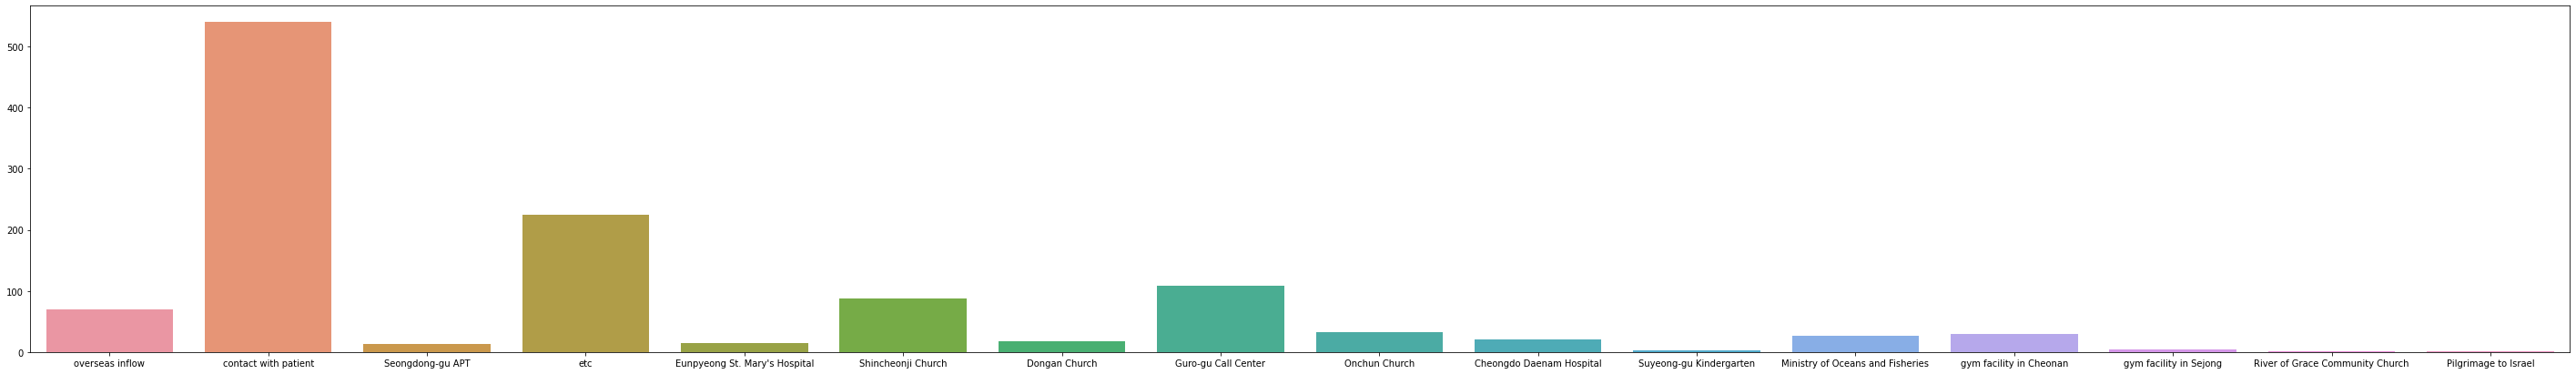

In [41]:
plt.figure(figsize=(50,7))
sns.barplot(howinfected, count_infection)

In [42]:
df_patientinfo.contact_number.unique()

array([7.500e+01, 3.100e+01, 1.700e+01, 9.000e+00, 2.000e+00, 4.300e+01,
       0.000e+00, 6.800e+01, 6.000e+00, 2.300e+01, 1.170e+02, 2.700e+01,
       8.000e+00,       nan, 1.091e+03, 1.310e+02, 1.600e+01, 1.400e+01,
       4.850e+02, 4.000e+00, 1.900e+01, 2.960e+02, 1.500e+01, 3.400e+01,
       1.000e+00, 3.700e+01, 2.200e+01, 7.000e+00, 1.000e+01, 2.800e+01,
       2.100e+01, 3.000e+00, 5.000e+00, 2.500e+01, 1.800e+01, 1.590e+02,
       1.100e+01, 3.000e+01, 4.100e+01, 7.100e+01, 3.800e+01, 1.300e+01,
       1.160e+03, 4.500e+02, 6.500e+01, 1.560e+02, 3.900e+01, 4.700e+01,
       8.600e+01, 7.400e+01, 1.200e+01, 4.600e+01, 6.400e+01, 6.600e+01,
       4.000e+01, 4.900e+01, 2.000e+01, 9.500e+01, 4.220e+02, 2.900e+02,
       5.300e+01, 4.500e+01, 2.400e+01, 3.500e+01, 5.100e+01, 1.300e+02,
       1.060e+02, 1.740e+02, 7.800e+01, 3.300e+01, 1.130e+02, 8.700e+01,
       8.400e+01])

In [0]:
numbercontacted=df_patientinfo.contact_number.unique()

count_seen=[]
for i in df_patientinfo.contact_number.unique():
    count_seen.append(df_patientinfo[df_patientinfo['contact_number']==i].count()['patient_id'])

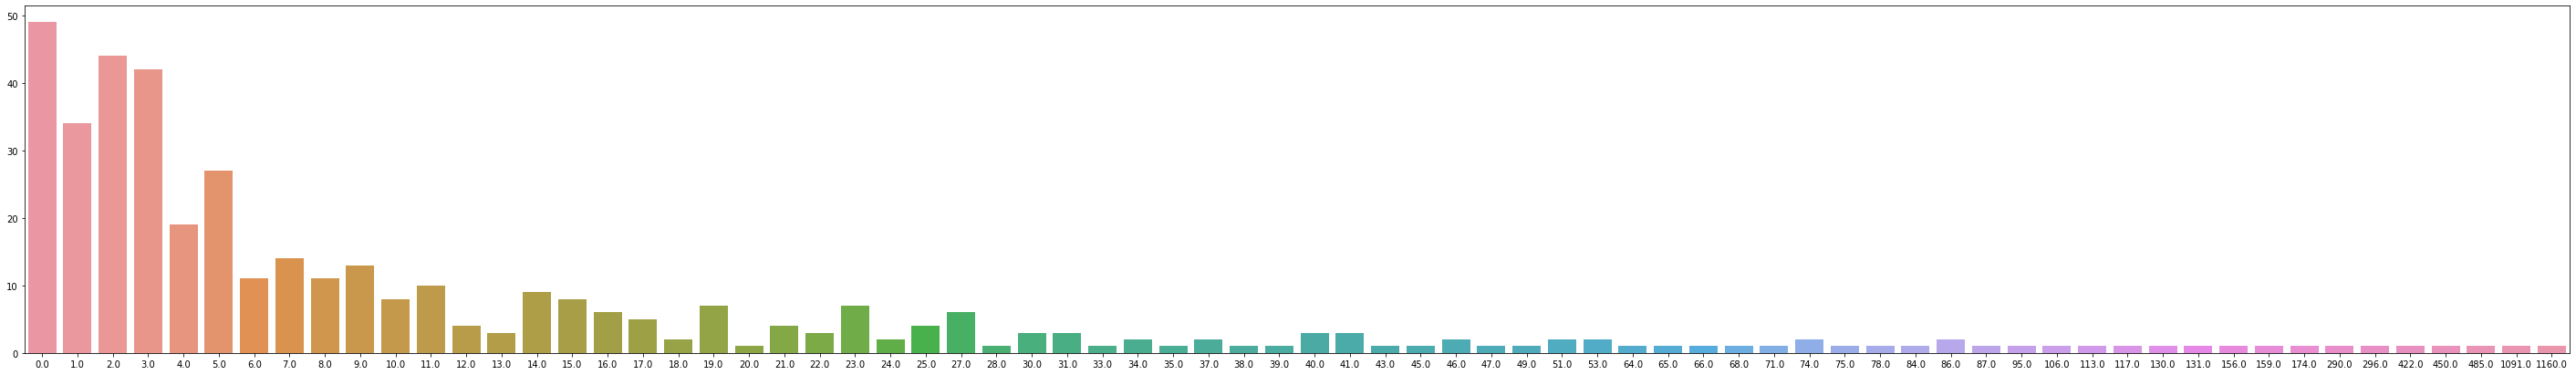

In [44]:
plt.figure(figsize=(50,7))
sns.barplot(numbercontacted, count_seen)

In [45]:
df_patientinfo.infection_case.unique        

<bound method Series.unique of 0            overseas inflow
1            overseas inflow
2       contact with patient
3            overseas inflow
4       contact with patient
                ...         
2238                     NaN
2239                     etc
2240                     etc
2241                     etc
2242                     etc
Name: infection_case, Length: 2243, dtype: object>

In [46]:
badcases=df_patientinfo.loc[df_patientinfo['infection_case']== 'etc']
badcases

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
17,1000000018,111.0,male,2000.0,20s,Korea,Seoul,etc,NaN,etc,NaN,NaN,NaN,NaN,2020-02-20,NaN,NaN,isolated
25,1000000026,420.0,male,1986.0,30s,Korea,Seoul,Seocho-gu,NaN,etc,NaN,NaN,NaN,2020-02-21,2020-02-22,2020-03-11,NaN,released
30,1000000031,780.0,male,1965.0,50s,Korea,Seoul,Songpa-gu,NaN,etc,NaN,NaN,NaN,NaN,2020-02-22,2020-03-19,NaN,released
34,1000000035,847.0,male,1984.0,30s,Korea,Seoul,etc,NaN,etc,NaN,NaN,NaN,2020-02-19,2020-02-25,2020-03-20,NaN,released
37,1000000038,907.0,male,1953.0,60s,Korea,Seoul,etc,NaN,etc,NaN,NaN,NaN,2020-02-24,2020-02-25,NaN,NaN,isolated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2191,6112000038,NaN,female,1961.0,50s,Korea,Gyeongsangnam-do,Changnyeong-gun,NaN,etc,NaN,NaN,NaN,NaN,2020-02-26,NaN,NaN,isolated
2239,7000000001,139.0,male,1998.0,20s,Korea,Jeju-do,Jeju-do,NaN,etc,NaN,NaN,87.0,NaN,2020-02-20,NaN,NaN,isolated
2240,7000000002,222.0,female,1998.0,20s,Korea,Jeju-do,Jeju-do,NaN,etc,NaN,NaN,84.0,NaN,2020-02-22,2020-03-07,NaN,released
2241,7000000003,4345.0,female,1972.0,40s,Korea,Jeju-do,etc,NaN,etc,NaN,NaN,21.0,NaN,2020-03-02,2020-03-15,NaN,released


In [47]:
df_patientinfof=df_patientinfo[df_patientinfo['infection_case'].notnull()]
df_patientinfof

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197,6113000044,NaN,female,1976.0,40s,Korea,Gyeongsangnam-do,Changwon-si,NaN,contact with patient,NaN,6.113000e+09,NaN,NaN,2020-02-27,NaN,NaN,released
2239,7000000001,139.0,male,1998.0,20s,Korea,Jeju-do,Jeju-do,NaN,etc,NaN,NaN,87.0,NaN,2020-02-20,NaN,NaN,isolated
2240,7000000002,222.0,female,1998.0,20s,Korea,Jeju-do,Jeju-do,NaN,etc,NaN,NaN,84.0,NaN,2020-02-22,2020-03-07,NaN,released
2241,7000000003,4345.0,female,1972.0,40s,Korea,Jeju-do,etc,NaN,etc,NaN,NaN,21.0,NaN,2020-03-02,2020-03-15,NaN,released


In [48]:
df_patientinfof2=df_patientinfof[df_patientinfof.infection_case != 'etc']
df_patientinfof2

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193,6113000040,NaN,male,1964.0,50s,Korea,Gyeongsangnam-do,Changwon-si,NaN,contact with patient,2.0,6.113000e+09,NaN,NaN,2020-02-26,NaN,NaN,isolated
2194,6106000041,NaN,male,1985.0,30s,Korea,Gyeongsangnam-do,Miryang-si,NaN,contact with patient,2.0,6.106000e+09,NaN,NaN,2020-02-26,NaN,NaN,released
2195,6113000042,NaN,male,1979.0,40s,Korea,Gyeongsangnam-do,Changwon-si,NaN,contact with patient,2.0,6.113000e+09,NaN,NaN,2020-02-26,NaN,NaN,isolated
2196,6104000043,NaN,male,1996.0,20s,Korea,Gyeongsangnam-do,Gimhae-si,NaN,Shincheonji Church,NaN,NaN,NaN,NaN,2020-02-26,NaN,NaN,released


In [49]:
goodresults=df_patientinfof2[df_patientinfof2.state=='released']
goodresults

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2190,6113000037,NaN,female,1967.0,50s,Korea,Gyeongsangnam-do,Changwon-si,NaN,contact with patient,2.0,6.113000e+09,NaN,NaN,2020-02-26,NaN,NaN,released
2192,6104000039,NaN,female,1955.0,60s,Korea,Gyeongsangnam-do,Gimhae-si,NaN,contact with patient,NaN,NaN,NaN,NaN,2020-02-26,NaN,NaN,released
2194,6106000041,NaN,male,1985.0,30s,Korea,Gyeongsangnam-do,Miryang-si,NaN,contact with patient,2.0,6.106000e+09,NaN,NaN,2020-02-26,NaN,NaN,released
2196,6104000043,NaN,male,1996.0,20s,Korea,Gyeongsangnam-do,Gimhae-si,NaN,Shincheonji Church,NaN,NaN,NaN,NaN,2020-02-26,NaN,NaN,released


In [50]:
goodresults.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167 entries, 0 to 2197
Data columns (total 18 columns):
patient_id            167 non-null int64
global_num            80 non-null float64
sex                   167 non-null object
birth_year            153 non-null float64
age                   167 non-null object
country               167 non-null object
province              167 non-null object
city                  158 non-null object
disease               0 non-null object
infection_case        167 non-null object
infection_order       32 non-null float64
infected_by           88 non-null float64
contact_number        89 non-null float64
symptom_onset_date    30 non-null object
confirmed_date        167 non-null object
released_date         111 non-null object
deceased_date         0 non-null object
state                 167 non-null object
dtypes: float64(5), int64(1), object(12)
memory usage: 24.8+ KB


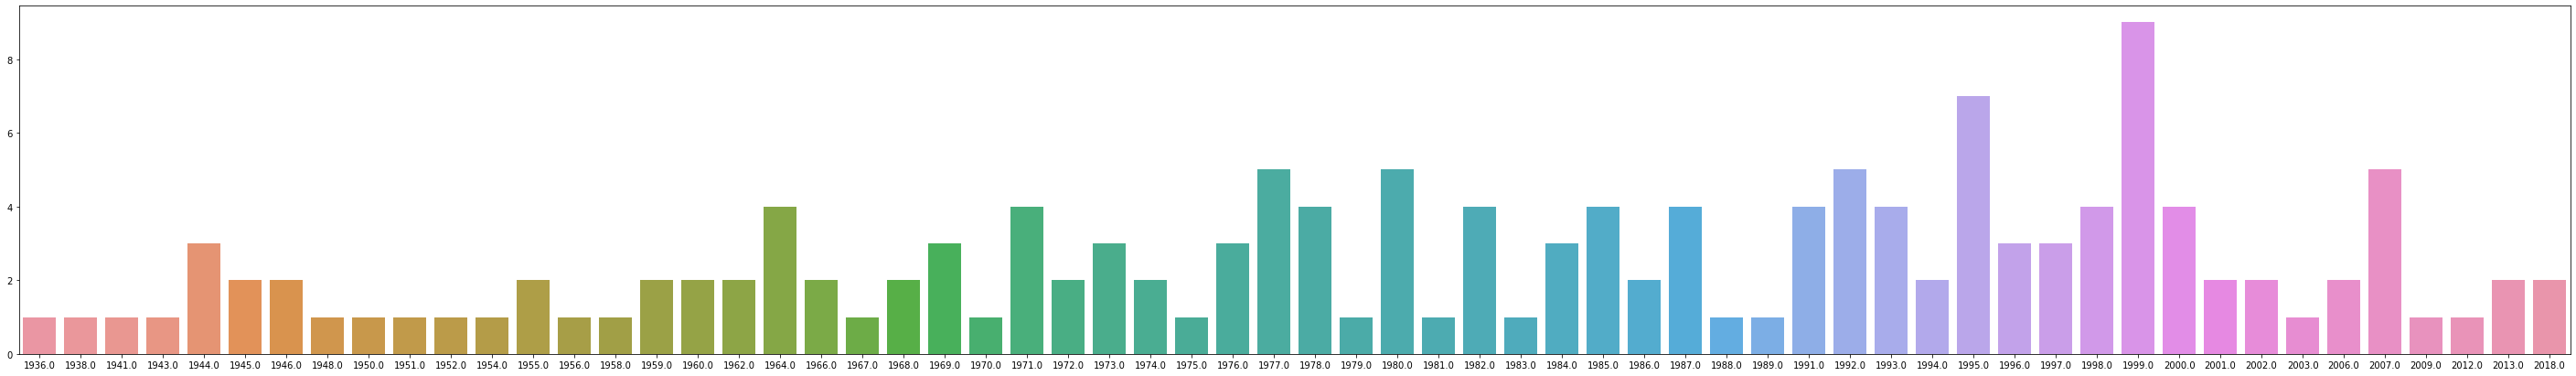

In [51]:
birthday=goodresults.birth_year.unique()

count_birthday=[]
for i in goodresults.birth_year.unique():
    count_birthday.append(goodresults[goodresults['birth_year']==i].count()['birth_year'])

plt.figure(figsize=(50,7))
sns.barplot(birthday, count_birthday)

#DF SearchTrend

In [52]:
df_searchtrend.head()

,date,cold,flu,pneumonia,coronavirus
0,2016-03-17,0.15554,0.34471,0.18181,0.01236
1,2016-03-18,0.14417,0.49416,0.17563,0.01027
2,2016-03-19,0.13290,0.39907,0.15145,0.01154
3,2016-03-20,0.13863,0.39662,0.14408,0.00945
4,2016-03-21,0.16735,0.56989,0.21199,0.00963


In [53]:
df_searchtrend.isnull().sum()

date           0
cold           0
flu            0
pneumonia      0
coronavirus    0
dtype: int64

#DF Time Series Info

In [54]:
df_timeage.head(20)

,date,time,age,confirmed,deceased
0,2020-03-02,0,0s,32,0
1,2020-03-02,0,10s,169,0
2,2020-03-02,0,20s,1235,0
3,2020-03-02,0,30s,506,1
4,2020-03-02,0,40s,633,1
5,2020-03-02,0,50s,834,5
6,2020-03-02,0,60s,530,6
7,2020-03-02,0,70s,192,6
8,2020-03-02,0,80s,81,3
9,2020-03-03,0,0s,34,0


In [146]:
df_timeage.deceased.sum()

1329

In [55]:
df_time.head()

,date,time,test,negative,confirmed,released,deceased
0,2020-01-20,16,1,0,1,0,0
1,2020-01-21,16,1,0,1,0,0
2,2020-01-22,16,4,3,1,0,0
3,2020-01-23,16,22,21,1,0,0
4,2020-01-24,16,27,25,2,0,0


In [56]:
df_time.isnull().sum()

date         0
time         0
test         0
negative     0
confirmed    0
released     0
deceased     0
dtype: int64

In [57]:
df_timegender.head()

,date,time,sex,confirmed,deceased
0,2020-03-02,0,male,1591,13
1,2020-03-02,0,female,2621,9
2,2020-03-03,0,male,1810,16
3,2020-03-03,0,female,3002,12
4,2020-03-04,0,male,1996,20


In [58]:
df_timegender.isnull().sum()

date         0
time         0
sex          0
confirmed    0
deceased     0
dtype: int64

In [59]:
df_timeprovince.head()

,date,time,province,confirmed,released,deceased
0,2020-01-20,16,Seoul,0,0,0
1,2020-01-20,16,Busan,0,0,0
2,2020-01-20,16,Daegu,0,0,0
3,2020-01-20,16,Incheon,1,0,0
4,2020-01-20,16,Gwangju,0,0,0


In [60]:
df_timeprovince.isnull().sum()

date         0
time         0
province     0
confirmed    0
released     0
deceased     0
dtype: int64

In [61]:
df_timeprovince['province'].count()

1071

#DF Weather

In [62]:
df_weather.head()

,code,province,date,avg_temp,min_temp,max_temp,precipitation,max_wind_speed,most_wind_direction,avg_relative_humidity
0,10000,Seoul,2016-03-17,9.3,2.0,14.7,0.0,3.2,70.0,40.9
1,10000,Seoul,2016-03-18,13.4,8.8,20.1,0.0,5.0,110.0,50.0
2,10000,Seoul,2016-03-19,11.4,6.6,18.1,0.0,4.8,320.0,58.3
3,10000,Seoul,2016-03-20,10.6,4.9,17.5,0.0,4.6,320.0,54.0
4,10000,Seoul,2016-03-21,9.9,5.5,16.1,0.0,5.4,320.0,54.1


In [63]:
df_weather.isnull().sum()

code                      0
province                  0
date                      0
avg_temp                 15
min_temp                  5
max_temp                  3
precipitation             0
max_wind_speed            9
most_wind_direction      29
avg_relative_humidity    20
dtype: int64

#KNN

In [64]:
df_patientinfo.shape

(2243, 18)

In [65]:
df_patientroute.shape

(175, 8)

In [66]:
df_casef.shape

(29, 9)

Let's focus on optimizing placement of officials to handle the most cases by finding the nearest centroid in relationship to case number.

In [0]:
from sklearn.neighbors import NearestCentroid

In [68]:
X=pd.concat([df_casef['longitude'], df_casef['latitude']], axis=1)
X

,longitude,latitude
0,126.884387,37.508163
1,127.056766,37.592888
2,126.9165,37.63369
3,127.0403,37.55713
4,127.006,37.57681
5,126.984377,37.562405
8,129.0771,35.21628
10,129.1124,35.16708
11,129.1256,35.20599
12,129.0633,35.17371


In [69]:
X.shape

(29, 2)

In [70]:
y= df_casef['confirmed']
y

0       79
1       24
2       14
3       13
4       10
5        7
8       34
10       6
11       6
12       4
15    4359
35      28
36       8
41      22
42      19
43      10
50      11
53     104
54       8
65     119
66      58
68      25
69      22
70      17
71      16
74      10
75       8
76       7
77       7
Name: confirmed, dtype: int64

In [71]:
clf=KNeighborsClassifier(metric='haversine')
clf.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='haversine',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [72]:
clf.predict([[126.884387,37.508163]])

array([7])

In [73]:
clf.predict([[126, 36]])

array([8])

#nearest_point

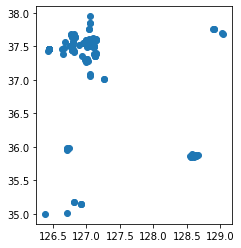

In [74]:
Xf=gdf_patientroutef
Xf.plot()

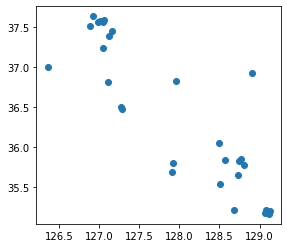

In [75]:
yf= gdf_casef
yf.plot()

In [0]:
def get_nearest_values(row, other_gdf, point_column='geometry', value_column="geometry"):
    """Find the nearest point and return the corresponding value from specified value column."""

    # Create an union of the other GeoDataFrame's geometries:
    other_points = other_gdf["geometry"].unary_union

    # Find the nearest points (uses euclidean geometry)
    nearest_geoms = nearest_points(row[point_column], other_points)

    # Get corresponding values from the other gdf
    nearest_data = other_gdf.loc[other_gdf["geometry"] == nearest_geoms[1]]


    nearest_location = nearest_data[value_column].to_numpy()[0]

    return nearest_location

In [77]:
unary_union = yf.unary_union
print(unary_union)

MULTIPOINT (126.354443 37.00035399999999, 126.884387 37.508163, 126.9165 37.63369, 126.984377 37.562405, 127.006 37.57680999999999, 127.0403 37.55713, 127.0517 37.2376, 127.056766 37.592888, 127.1139 36.81503, 127.1218 37.38833, 127.161627 37.455687, 127.265172 36.504713, 127.289 36.48025, 127.9127 35.68556, 127.917805 35.805681, 127.9552 36.82422, 128.4941 36.0581, 128.5008 35.54127, 128.5667 35.84008, 128.6866 35.22115, 128.7368 35.64887, 128.7373 35.82558, 128.7621 35.84819, 128.801498 35.782149, 128.9099 36.92757, 129.0633 35.17371, 129.0771 35.21628, 129.1124 35.16708, 129.1256 35.20599)


In [0]:
Xf["infection_case"] = Xf.apply(get_nearest_values, other_gdf=yf, point_column='geometry', value_column='geometry', axis=1)

In [0]:
Xf["case_id"] = Xf.apply(get_nearest_values, other_gdf=yf, point_column='geometry', value_column='case_id', axis=1)

In [0]:
Xult=pd.merge(Xf, greatpoints, on='case_id')

In [81]:
Xult

,patient_id,global_num,date,province,city,latitude_x,longitude_x,geometry,infection_case,case_id,latitude_y,longitude_y
0,1400000001,1,2020-01-19,Incheon,Jung-gu,37.460459,126.440680,POINT (126.44068 37.46046),POINT (126.884387 37.508163),1000001,37.508163,126.884387
1,1400000001,1,2020-01-20,Incheon,Seo-gu,37.478832,126.668558,POINT (126.66856 37.47883),POINT (126.884387 37.508163),1000001,37.508163,126.884387
2,1000000001,2,2020-01-22,Gyeonggi-do,Gimpo-si,37.562143,126.801884,POINT (126.80188 37.56214),POINT (126.884387 37.508163),1000001,37.508163,126.884387
3,2000000001,3,2020-01-20,Incheon,Jung-gu,37.460459,126.440680,POINT (126.44068 37.46046),POINT (126.884387 37.508163),1000001,37.508163,126.884387
4,2000000002,4,2020-01-20,Incheon,Jung-gu,37.460459,126.440680,POINT (126.44068 37.46046),POINT (126.884387 37.508163),1000001,37.508163,126.884387
...,...,...,...,...,...,...,...,...,...,...,...,...
170,1000000009,19,2020-02-01,Seoul,Songpa-gu,37.495414,127.117521,POINT (127.11752 37.49541),POINT (127.161627 37.455687),2000004,37.455687,127.161627
171,2000000009,26,2020-02-09,Gyeonggi-do,Anseong-si,37.017297,127.260422,POINT (127.26042 37.01730),POINT (127.1139 36.81503),4100001,36.81503,127.1139
172,2000000010,27,2020-02-09,Gyeonggi-do,Anseong-si,37.017297,127.260422,POINT (127.26042 37.01730),POINT (127.1139 36.81503),4100001,36.81503,127.1139
173,1000000014,30,2020-02-10,Incheon,Jung-gu,37.423537,126.421426,POINT (126.42143 37.42354),POINT (126.354443 37.00035399999999),4100002,37.000354,126.354443


Now that I have Route geometry and the epicenter geometry all in one  geodataframe lets test the function

In [82]:
d = {'latitude': [37], 'longitude': [126]}
dftest = pd.DataFrame(data=d)
dftest

,latitude,longitude
0,37,126


In [83]:
def create_gdf_test(dftest, lng, lat):
    "Convert pandas dataframe into a Geopandas GeoDataFrame"
    crs = {'init': 'EPSG:3395'}
    xlng= pd.to_numeric(dftest['longitude'], errors='coerce')
    ylat= pd.to_numeric(dftest['latitude'], errors='coerce')
    geometry = [Point(xy) for xy in zip(xlng, ylat)]
    gdftest = gpd.GeoDataFrame(dftest, crs= crs , geometry=geometry)
    return gdftest
gdftestf =  create_gdf_test(dftest, "longitude", "latitude")
gdftestf.tail()

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,latitude,longitude,geometry
0,37,126,POINT (126.00000 37.00000)


In [0]:
Xtest=gdftestf

In [85]:
Xtest.apply(get_nearest_values, other_gdf=yf, point_column='geometry', value_column='geometry', axis=1)


0    POINT (126.354443 37.00035399999999)
dtype: object

In [86]:
Xtest.apply(get_nearest_values, other_gdf=yf, point_column='geometry', value_column='case_id', axis=1)

0    4100002
dtype: int64

In [87]:
testresult=df_casef[df_casef.case_id == 4100002]
testresult

,case_id,province,city,group,infection_case,confirmed,latitude,longitude,geometry
54,4100002,Chungcheongnam-do,Seosan-si,True,Seosan-si Laboratory,8,37.000354,126.354443,POINT (126.35444 37.00035)


#merging dataframes

In [88]:
df_patientinfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2243 entries, 0 to 2242
Data columns (total 18 columns):
patient_id            2243 non-null int64
global_num            1337 non-null float64
sex                   2147 non-null object
birth_year            1789 non-null float64
age                   1985 non-null object
country               2243 non-null object
province              2243 non-null object
city                  2176 non-null object
disease               19 non-null object
infection_case        1193 non-null object
infection_order       42 non-null float64
infected_by           475 non-null float64
contact_number        413 non-null float64
symptom_onset_date    194 non-null object
confirmed_date        2098 non-null object
released_date         233 non-null object
deceased_date         30 non-null object
state                 2147 non-null object
dtypes: float64(5), int64(1), object(12)
memory usage: 315.5+ KB


In [89]:
df_patientinfo.tail()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
2238,6100000085,NaN,male,1990.0,30s,Korea,Gyeongsangnam-do,Changwon-si,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-16,NaN,NaN,NaN
2239,7000000001,139.0,male,1998.0,20s,Korea,Jeju-do,Jeju-do,NaN,etc,NaN,NaN,87.0,NaN,2020-02-20,NaN,NaN,isolated
2240,7000000002,222.0,female,1998.0,20s,Korea,Jeju-do,Jeju-do,NaN,etc,NaN,NaN,84.0,NaN,2020-02-22,2020-03-07,NaN,released
2241,7000000003,4345.0,female,1972.0,40s,Korea,Jeju-do,etc,NaN,etc,NaN,NaN,21.0,NaN,2020-03-02,2020-03-15,NaN,released
2242,7000000004,5534.0,male,1974.0,40s,Korea,Jeju-do,Jeju-do,NaN,etc,NaN,NaN,74.0,NaN,2020-03-04,NaN,NaN,isolated


In [90]:
merged_patientinfo=pd.merge(df_patientinfof, df_region, on='city')
merged_patientinfo

,patient_id,global_num,sex,birth_year,age,country,province_x,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,code,province_y,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,10040,Seoul,37.551166,126.849506,36,56,1,1.17,14.39,5.7,1080
1,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,11010,Busan,35.212424,128.980680,17,21,0,1.43,11.84,5.0,147
2,1000000027,593.0,male,1968.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,NaN,NaN,NaN,NaN,2020-02-23,2020-03-04,NaN,released,10040,Seoul,37.551166,126.849506,36,56,1,1.17,14.39,5.7,1080
3,1000000027,593.0,male,1968.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,NaN,NaN,NaN,NaN,2020-02-23,2020-03-04,NaN,released,11010,Busan,35.212424,128.980680,17,21,0,1.43,11.84,5.0,147
4,1000000106,6384.0,male,1986.0,30s,Korea,Seoul,Gangseo-gu,NaN,contact with patient,NaN,NaN,NaN,NaN,2020-03-06,NaN,NaN,isolated,10040,Seoul,37.551166,126.849506,36,56,1,1.17,14.39,5.7,1080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1376,6112000038,NaN,female,1961.0,50s,Korea,Gyeongsangnam-do,Changnyeong-gun,NaN,etc,NaN,NaN,NaN,NaN,2020-02-26,NaN,NaN,isolated,61120,Gyeongsangnam-do,35.544603,128.492330,17,20,0,0.80,29.80,18.4,129
1377,6106000041,NaN,male,1985.0,30s,Korea,Gyeongsangnam-do,Miryang-si,NaN,contact with patient,2.0,6.106000e+09,NaN,NaN,2020-02-26,NaN,NaN,released,61060,Gyeongsangnam-do,35.503827,128.746604,21,25,0,1.39,27.31,16.3,178
1378,7000000001,139.0,male,1998.0,20s,Korea,Jeju-do,Jeju-do,NaN,etc,NaN,NaN,87.0,NaN,2020-02-20,NaN,NaN,isolated,70000,Jeju-do,33.488936,126.500423,113,123,4,1.53,15.10,6.4,1245
1379,7000000002,222.0,female,1998.0,20s,Korea,Jeju-do,Jeju-do,NaN,etc,NaN,NaN,84.0,NaN,2020-02-22,2020-03-07,NaN,released,70000,Jeju-do,33.488936,126.500423,113,123,4,1.53,15.10,6.4,1245


In [91]:
merged_patientinfo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1381 entries, 0 to 1380
Data columns (total 29 columns):
patient_id                  1381 non-null int64
global_num                  779 non-null float64
sex                         1379 non-null object
birth_year                  1194 non-null float64
age                         1262 non-null object
country                     1381 non-null object
province_x                  1381 non-null object
city                        1381 non-null object
disease                     9 non-null object
infection_case              1381 non-null object
infection_order             41 non-null float64
infected_by                 522 non-null float64
contact_number              409 non-null float64
symptom_onset_date          197 non-null object
confirmed_date              1362 non-null object
released_date               188 non-null object
deceased_date               10 non-null object
state                       1278 non-null object
code               

Let's see if we can find where the virus is spreading and maybe some properties of where the virus is spreading to or originating from

In [92]:
merged=pd.merge(df_patientroute, merged_patientinfo, on='patient_id')
merged

,patient_id,global_num_x,date,province,city_x,latitude_x,longitude_x,geometry,infection_case_x,global_num_y,sex,birth_year,age,country,province_x,city_y,disease,infection_case_y,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,code,province_y,latitude_y,longitude_y,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
0,1000000001,2,2020-01-22,Gyeonggi-do,Gimpo-si,37.562143,126.801884,POINT (126.80188 37.56214),POINT (126.884387 37.508163),2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,10040,Seoul,37.551166,126.849506,36,56,1,1.17,14.39,5.7,1080
1,1000000001,2,2020-01-22,Gyeonggi-do,Gimpo-si,37.562143,126.801884,POINT (126.80188 37.56214),POINT (126.884387 37.508163),2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,11010,Busan,35.212424,128.980680,17,21,0,1.43,11.84,5.0,147
2,1000000001,2,2020-01-23,Seoul,Jung-gu,37.567454,127.005627,POINT (127.00563 37.56745),POINT (127.006 37.57680999999999),2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,10040,Seoul,37.551166,126.849506,36,56,1,1.17,14.39,5.7,1080
3,1000000001,2,2020-01-23,Seoul,Jung-gu,37.567454,127.005627,POINT (127.00563 37.56745),POINT (127.006 37.57680999999999),2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,11010,Busan,35.212424,128.980680,17,21,0,1.43,11.84,5.0,147
4,2000000001,3,2020-01-20,Incheon,Jung-gu,37.460459,126.440680,POINT (126.44068 37.46046),POINT (126.884387 37.508163),3.0,male,1966.0,50s,Korea,Gyeonggi-do,Goyang-si,NaN,overseas inflow,1.0,NaN,16.0,NaN,2020-01-26,2020-02-12,NaN,released,20020,Gyeonggi-do,37.658363,126.831961,84,171,2,1.88,12.82,5.2,1608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,1000000014,30,2020-02-13,Seoul,Jongno-gu,37.572793,127.015975,POINT (127.01597 37.57279),POINT (127.006 37.57680999999999),30.0,female,1952.0,60s,Korea,Seoul,Jongno-gu,NaN,contact with patient,5.0,1.000000e+09,27.0,2020-02-06,2020-02-16,2020-03-12,NaN,released,10230,Seoul,37.572999,126.979189,13,17,3,1.71,18.27,6.8,668
153,1000000014,30,2020-02-14,Seoul,Jongno-gu,37.572596,127.015270,POINT (127.01527 37.57260),POINT (127.006 37.57680999999999),30.0,female,1952.0,60s,Korea,Seoul,Jongno-gu,NaN,contact with patient,5.0,1.000000e+09,27.0,2020-02-06,2020-02-16,2020-03-12,NaN,released,10230,Seoul,37.572999,126.979189,13,17,3,1.71,18.27,6.8,668
154,1000000014,30,2020-02-14,Seoul,Jongno-gu,37.574541,127.015927,POINT (127.01593 37.57454),POINT (127.006 37.57680999999999),30.0,female,1952.0,60s,Korea,Seoul,Jongno-gu,NaN,contact with patient,5.0,1.000000e+09,27.0,2020-02-06,2020-02-16,2020-03-12,NaN,released,10230,Seoul,37.572999,126.979189,13,17,3,1.71,18.27,6.8,668
155,1000000014,30,2020-02-15,Seoul,Seongbuk-gu,37.587055,127.026830,POINT (127.02683 37.58705),POINT (127.006 37.57680999999999),30.0,female,1952.0,60s,Korea,Seoul,Jongno-gu,NaN,contact with patient,5.0,1.000000e+09,27.0,2020-02-06,2020-02-16,2020-03-12,NaN,released,10230,Seoul,37.572999,126.979189,13,17,3,1.71,18.27,6.8,668


In [93]:
types_states=merged['state'].unique()
types_states

array(['released', 'isolated'], dtype=object)

My merged table shows isolated and released cases. This is useful for potentially predicting what conditions allow you to make it through the virus.

In [94]:
types_all_states=merged_patientinfo['state'].unique()
types_all_states

array(['released', 'isolated', nan, 'deceased'], dtype=object)

To describe this table, the _x values represent the route patients take, the _y values represent the nearest epicenters or case_ids according to euclidean geometry. Additionally, the table includes the patient's info and region info.

#knn

First we will see if knearestneighbors can take in a route and predict a state or at the very least provide some insight

In [0]:
Xk=pd.concat([merged['latitude_x'], merged['longitude_x'], merged['birth_year']], axis=1)

In [0]:
one_hot = pd.get_dummies(merged['state'])

In [0]:
df = merged.drop('state',axis = 1)

In [0]:
mergedoh=merged.join(one_hot)

In [99]:
mergedoh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157 entries, 0 to 156
Data columns (total 39 columns):
patient_id                  157 non-null int64
global_num_x                157 non-null int64
date                        157 non-null object
province                    157 non-null object
city_x                      157 non-null object
latitude_x                  157 non-null float64
longitude_x                 157 non-null float64
geometry                    157 non-null geometry
infection_case_x            157 non-null object
global_num_y                157 non-null float64
sex                         157 non-null object
birth_year                  157 non-null float64
age                         157 non-null object
country                     157 non-null object
province_x                  157 non-null object
city_y                      157 non-null object
disease                     0 non-null object
infection_case_y            157 non-null object
infection_order             1

In [100]:
mergedoh.head()

,patient_id,global_num_x,date,province,city_x,latitude_x,longitude_x,geometry,infection_case_x,global_num_y,sex,birth_year,age,country,province_x,city_y,disease,infection_case_y,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,code,province_y,latitude_y,longitude_y,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count,isolated,released
0,1000000001,2,2020-01-22,Gyeonggi-do,Gimpo-si,37.562143,126.801884,POINT (126.80188 37.56214),POINT (126.884387 37.508163),2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,10040,Seoul,37.551166,126.849506,36,56,1,1.17,14.39,5.7,1080,0,1
1,1000000001,2,2020-01-22,Gyeonggi-do,Gimpo-si,37.562143,126.801884,POINT (126.80188 37.56214),POINT (126.884387 37.508163),2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,11010,Busan,35.212424,128.980680,17,21,0,1.43,11.84,5.0,147,0,1
2,1000000001,2,2020-01-23,Seoul,Jung-gu,37.567454,127.005627,POINT (127.00563 37.56745),POINT (127.006 37.57680999999999),2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,10040,Seoul,37.551166,126.849506,36,56,1,1.17,14.39,5.7,1080,0,1
3,1000000001,2,2020-01-23,Seoul,Jung-gu,37.567454,127.005627,POINT (127.00563 37.56745),POINT (127.006 37.57680999999999),2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,11010,Busan,35.212424,128.980680,17,21,0,1.43,11.84,5.0,147,0,1
4,2000000001,3,2020-01-20,Incheon,Jung-gu,37.460459,126.440680,POINT (126.44068 37.46046),POINT (126.884387 37.508163),3.0,male,1966.0,50s,Korea,Gyeonggi-do,Goyang-si,NaN,overseas inflow,1.0,NaN,16.0,NaN,2020-01-26,2020-02-12,NaN,released,20020,Gyeonggi-do,37.658363,126.831961,84,171,2,1.88,12.82,5.2,1608,0,1


In [0]:
y_one_hot= pd.concat([mergedoh['isolated'], mergedoh['released']], axis=1)

In [0]:
neigh_m= KNeighborsClassifier(weights='distance', algorithm='brute', p=1)

In [103]:
neigh_m.fit(Xk, y_one_hot)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=1,
                     weights='distance')

In [0]:
pred=neigh_m.predict(Xk)

In [105]:
print(accuracy_score(y_one_hot, pred))
print(classification_report(y_one_hot, pred))

0.9872611464968153
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       1.00      0.99      1.00       150

   micro avg       1.00      0.99      0.99       157
   macro avg       1.00      0.93      0.96       157
weighted avg       1.00      0.99      0.99       157
 samples avg       0.99      0.99      0.99       157



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
saved_model = plk.dumps(neigh_m)

In [0]:
knn_from_pickle = plk.loads(saved_model) 

In [108]:
X_test_pkl=[[127.006 , 37.57680999999999, 1964.0]]
knn_from_pickle.predict(X_test_pkl)

array([[0, 1]], dtype=uint8)

Good the model works

In [0]:
plk.dump(knn_from_pickle, open('neigh_m.plk', 'wb'))

#kmodes experimentation

Now to test all possible states

In [110]:
one_hot = pd.get_dummies(merged_patientinfo['state'])
dfpi = merged.drop('state',axis = 1)
merged_patientinfooh=merged_patientinfo.join(one_hot)
merged_patientinfooh.tail()

,patient_id,global_num,sex,birth_year,age,country,province_x,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,code,province_y,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count,deceased,isolated,released
1376,6112000038,NaN,female,1961.0,50s,Korea,Gyeongsangnam-do,Changnyeong-gun,NaN,etc,NaN,NaN,NaN,NaN,2020-02-26,NaN,NaN,isolated,61120,Gyeongsangnam-do,35.544603,128.492330,17,20,0,0.80,29.80,18.4,129,0,1,0
1377,6106000041,NaN,male,1985.0,30s,Korea,Gyeongsangnam-do,Miryang-si,NaN,contact with patient,2.0,6.106000e+09,NaN,NaN,2020-02-26,NaN,NaN,released,61060,Gyeongsangnam-do,35.503827,128.746604,21,25,0,1.39,27.31,16.3,178,0,0,1
1378,7000000001,139.0,male,1998.0,20s,Korea,Jeju-do,Jeju-do,NaN,etc,NaN,NaN,87.0,NaN,2020-02-20,NaN,NaN,isolated,70000,Jeju-do,33.488936,126.500423,113,123,4,1.53,15.10,6.4,1245,0,1,0
1379,7000000002,222.0,female,1998.0,20s,Korea,Jeju-do,Jeju-do,NaN,etc,NaN,NaN,84.0,NaN,2020-02-22,2020-03-07,NaN,released,70000,Jeju-do,33.488936,126.500423,113,123,4,1.53,15.10,6.4,1245,0,0,1
1380,7000000004,5534.0,male,1974.0,40s,Korea,Jeju-do,Jeju-do,NaN,etc,NaN,NaN,74.0,NaN,2020-03-04,NaN,NaN,isolated,70000,Jeju-do,33.488936,126.500423,113,123,4,1.53,15.10,6.4,1245,0,1,0


In [124]:
merged_patientinfooh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1381 entries, 0 to 1380
Data columns (total 32 columns):
patient_id                  1381 non-null int64
global_num                  779 non-null float64
sex                         1379 non-null object
birth_year                  1194 non-null float64
age                         1262 non-null object
country                     1381 non-null object
province_x                  1381 non-null object
city                        1381 non-null object
disease                     9 non-null object
infection_case              1381 non-null object
infection_order             41 non-null float64
infected_by                 522 non-null float64
contact_number              409 non-null float64
symptom_onset_date          197 non-null object
confirmed_date              1362 non-null object
released_date               188 non-null object
deceased_date               10 non-null object
state                       1278 non-null object
code               

In [111]:
merged_patientinfooh.birth_year.unique()

array([1964., 1968., 1986., 1971., 1960., 1966., 1972., 1962., 1992.,
       1999., 1967., 1994., 1982., 1978., 2002., 1987., 2005., 1973.,
       1984., 1953., 1995., 1938., 1952., 1945., 1944., 1941., 1936.,
       1950., 1991., 1998., 1976., 2008., 1970., 1969., 1981., 1963.,
       1983., 1965., 2000., 1979., 1993., 1997., 1951., 1958., 1985.,
       1955., 1943., 1961., 1980., 1975., 1974., 2012., 2001., 1954.,
       1977., 1956., 1937., 1935., 1989., 1959., 1990., 1949., 1939.,
       1996., 1988., 2013., 2003., 2007., 2020., 2004., 2006., 1929.,
       1934., 1947.,   nan, 2015., 1948., 1957., 1946., 1932., 2010.,
       2009., 2018., 1942., 2014., 2011., 2017., 1930., 2019.])

In [112]:
merged_patientinfooh.isnull().sum()

patient_id                     0
global_num                   602
sex                            2
birth_year                   187
age                          119
country                        0
province_x                     0
city                           0
disease                     1372
infection_case                 0
infection_order             1340
infected_by                  859
contact_number               972
symptom_onset_date          1184
confirmed_date                19
released_date               1193
deceased_date               1371
state                        103
code                           0
province_y                     0
latitude                       0
longitude                      0
elementary_school_count        0
kindergarten_count             0
university_count               0
academy_ratio                  0
elderly_population_ratio       0
elderly_alone_ratio            0
nursing_home_count             0
deceased                       0
isolated  

In [0]:
gmerged_patientinfooh=merged_patientinfooh.dropna(subset=['birth_year'])

In [114]:
datatable=pd.concat([gmerged_patientinfooh['birth_year'], gmerged_patientinfooh['deceased'], gmerged_patientinfooh['isolated'], gmerged_patientinfooh['released']], axis=1)
datatable

,birth_year,deceased,isolated,released
0,1964.0,0,0,1
1,1964.0,0,0,1
2,1968.0,0,0,1
3,1968.0,0,0,1
4,1986.0,0,1,0
...,...,...,...,...
1376,1961.0,0,1,0
1377,1985.0,0,0,1
1378,1998.0,0,1,0
1379,1998.0,0,0,1


In [0]:
from kmodes.kmodes import KModes
km = KModes(n_clusters=3, init='Huang', n_init=5, verbose=1)

In [116]:
km.fit(datatable)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 326, cost: 1153.0
Run 1, iteration: 2/100, moves: 4, cost: 1153.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 112, cost: 1244.0
Run 2, iteration: 2/100, moves: 0, cost: 1244.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 115, cost: 1253.0
Run 3, iteration: 2/100, moves: 0, cost: 1253.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 13, cost: 1249.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 1693.0
Best run was number 1


KModes(cat_dissim=<function matching_dissim at 0x7f7921706268>, init='Huang',
       max_iter=100, n_clusters=3, n_init=5, n_jobs=1, random_state=None,
       verbose=1)

In [117]:
km.cluster_centroids_

array([[1.969e+03, 0.000e+00, 1.000e+00, 0.000e+00],
       [1.978e+03, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.995e+03, 0.000e+00, 0.000e+00, 1.000e+00]])

In [0]:
saved_kmodes_model = plk.dumps(km)

In [0]:
km_from_pickle = plk.loads(saved_kmodes_model) 

In [121]:
X_test_pkl_km=[[1956]]
km_from_pickle.predict(X_test_pkl_km)

array([0], dtype=uint16)

array[0] means that it could be compatable with any cluster, that is not very ideal. Kmodes is best with categorical features that are one hotted and birth_year is not great to one hot since there are many different types of entries for birth year. Let's look for a different feature to try this on.

In [129]:
merged_patientinfooh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1381 entries, 0 to 1380
Data columns (total 32 columns):
patient_id                  1381 non-null int64
global_num                  779 non-null float64
sex                         1379 non-null object
birth_year                  1194 non-null float64
age                         1262 non-null object
country                     1381 non-null object
province_x                  1381 non-null object
city                        1381 non-null object
disease                     9 non-null object
infection_case              1381 non-null object
infection_order             41 non-null float64
infected_by                 522 non-null float64
contact_number              409 non-null float64
symptom_onset_date          197 non-null object
confirmed_date              1362 non-null object
released_date               188 non-null object
deceased_date               10 non-null object
state                       1278 non-null object
code               

In [0]:
completedata=merged_patientinfooh.dropna(axis=1)

In [133]:
completedata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1381 entries, 0 to 1380
Data columns (total 19 columns):
patient_id                  1381 non-null int64
country                     1381 non-null object
province_x                  1381 non-null object
city                        1381 non-null object
infection_case              1381 non-null object
code                        1381 non-null int64
province_y                  1381 non-null object
latitude                    1381 non-null float64
longitude                   1381 non-null float64
elementary_school_count     1381 non-null int64
kindergarten_count          1381 non-null int64
university_count            1381 non-null int64
academy_ratio               1381 non-null float64
elderly_population_ratio    1381 non-null float64
elderly_alone_ratio         1381 non-null float64
nursing_home_count          1381 non-null int64
deceased                    1381 non-null uint8
isolated                    1381 non-null uint8
released      

In [142]:
completedata.deceased.sum()

10

There are 10 deaths in the dataset so it may be difficult for a model to predict the deceased status.

In [0]:
from kmodes.kmodes import KModes
km2 = KModes(n_clusters=24, init='Huang', n_init=5, verbose=1)

In [140]:
km2.fit(completedata)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 221, cost: 10862.0
Run 1, iteration: 2/100, moves: 90, cost: 10814.0
Run 1, iteration: 3/100, moves: 2, cost: 10814.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 265, cost: 11335.0
Run 2, iteration: 2/100, moves: 88, cost: 11286.0
Run 2, iteration: 3/100, moves: 51, cost: 11253.0
Run 2, iteration: 4/100, moves: 2, cost: 11253.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 246, cost: 11153.0
Run 3, iteration: 2/100, moves: 92, cost: 11092.0
Run 3, iteration: 3/100, moves: 8, cost: 11092.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 361, cost: 11135.0
Run 4, iteration: 2/100, moves: 130, cost: 11085.0
Run 4, iteration: 3/100, moves: 41, cost: 11056.0
Run 4, iteration: 4/100, mov

KModes(cat_dissim=<function matching_dissim at 0x7f7921706268>, init='Huang',
       max_iter=100, n_clusters=24, n_init=5, n_jobs=1, random_state=None,
       verbose=1)

In [141]:
km2.cluster_centroids_

array([['1100000011', 'Korea', 'Chungcheongnam-do', 'Cheonan-si',
        'contact with patient', '41120', 'Chungcheongnam-do', '36.81498',
        '127.113868', '75', '112', '6', '1.91', '10.42', '4.5', '1069',
        '0', '1', '0'],
       ['1000000136', 'Korea', 'Seoul', 'Gwanak-gu',
        'Guro-gu Call Center', '10050', 'Seoul', '37.47829',
        '126.951502', '22', '33', '1', '0.89', '15.12', '4.9', '909',
        '0', '1', '0'],
       ['1600000019', 'Korea', 'Daejeon', 'Seo-gu', 'etc', '11110',
        'Busan', '35.098135', '129.024193', '17', '9', '0', '0.83',
        '24.36', '12.3', '235', '0', '1', '0'],
       ['1600000002', 'Korea', 'Busan', 'Dongnae-gu',
        'Shincheonji Church', '11060', 'Busan', '35.205059999999996',
        '129.083673', '22', '31', '0', '1.98', '17.53', '7.7', '608',
        '0', '0', '1'],
       ['1400000006', 'Korea', 'Gyeongsangbuk-do', 'Yeongcheon-si',
        'etc', '60150', 'Gyeongsangbuk-do', '35.973268', '128.938603',
        '18', '

In [145]:
deaths=completedata.loc[completedata['deceased']== 1]
deaths

,patient_id,country,province_x,city,infection_case,code,province_y,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count,deceased,isolated,released
905,2000000039,Mongolia,Gyeonggi-do,Namyangju-si,etc,20090,Gyeonggi-do,37.635791,127.216552,64,110,1,1.38,13.44,5.0,912,1,0,0
1078,3014000001,Korea,Gangwon-do,Taebaek-si,contact with patient,30140,Gangwon-do,37.164060,128.985736,12,12,1,1.16,23.88,12.8,64,1,0,0
1294,6015000035,Korea,Gyeongsangbuk-do,Yeongcheon-si,etc,60150,Gyeongsangbuk-do,35.973268,128.938603,18,23,1,0.83,27.32,15.3,192,1,0,0
1315,6020100054,Korea,Gyeongsangbuk-do,Cheongdo-gun,Cheongdo Daenam Hospital,60200,Gyeongsangbuk-do,35.647361,128.734382,11,14,0,0.63,36.55,21.0,85,1,0,0
1316,6020100055,Korea,Gyeongsangbuk-do,Cheongdo-gun,Cheongdo Daenam Hospital,60200,Gyeongsangbuk-do,35.647361,128.734382,11,14,0,0.63,36.55,21.0,85,1,0,0
1317,6020100104,Korea,Gyeongsangbuk-do,Cheongdo-gun,Cheongdo Daenam Hospital,60200,Gyeongsangbuk-do,35.647361,128.734382,11,14,0,0.63,36.55,21.0,85,1,0,0
1318,6020100107,Korea,Gyeongsangbuk-do,Cheongdo-gun,Cheongdo Daenam Hospital,60200,Gyeongsangbuk-do,35.647361,128.734382,11,14,0,0.63,36.55,21.0,85,1,0,0
1319,6020100205,Korea,Gyeongsangbuk-do,Cheongdo-gun,Cheongdo Daenam Hospital,60200,Gyeongsangbuk-do,35.647361,128.734382,11,14,0,0.63,36.55,21.0,85,1,0,0
1320,6020100286,Korea,Gyeongsangbuk-do,Cheongdo-gun,Cheongdo Daenam Hospital,60200,Gyeongsangbuk-do,35.647361,128.734382,11,14,0,0.63,36.55,21.0,85,1,0,0
1321,6020100298,Korea,Gyeongsangbuk-do,Cheongdo-gun,Cheongdo Daenam Hospital,60200,Gyeongsangbuk-do,35.647361,128.734382,11,14,0,0.63,36.55,21.0,85,1,0,0


#DF Seoul Information

In [130]:
pd_seoul=pd.read_csv('SeoulFloating.csv')
pd_seoul.head()

,date,hour,birth_year,sex,province,city,fp_num
0,2020-01-01,0,20,female,Seoul,Dobong-gu,19140
1,2020-01-01,0,20,male,Seoul,Dobong-gu,19950
2,2020-01-01,0,20,female,Seoul,Dongdaemun-gu,25450
3,2020-01-01,0,20,male,Seoul,Dongdaemun-gu,27050
4,2020-01-01,0,20,female,Seoul,Dongjag-gu,28880


#References

https://automating-gis-processes.github.io/site/develop/notebooks/L3/nearest-neighbour.html

was helpful for nearest neighbor analysis

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

Kmodes inherits some similar properties as kmeans and that makes it useful
like for example .fit and .fit_predict